### Читаем результат детектора и изображения

In [1]:
import cv2
from PIL import Image
import numpy as np

from IPython.display import display

In [2]:
# Читаем все изображения из директории
def read_all_images_from(directory):
    from os import listdir
    from os.path import isfile, join
    images = []
    for file in listdir(directory):
        file_path = join(directory, file)
        if isfile(file_path):
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            images.append(image)
    return images

In [3]:
segmaps_path = "/kaggle/input/abbyy-dataset/Test/Segmaps"
images_path = "/kaggle/input/abbyy-dataset/Test/Image"
segmaps = read_all_images_from(segmaps_path)
images = read_all_images_from(images_path)
assert len(segmaps) == len(images)

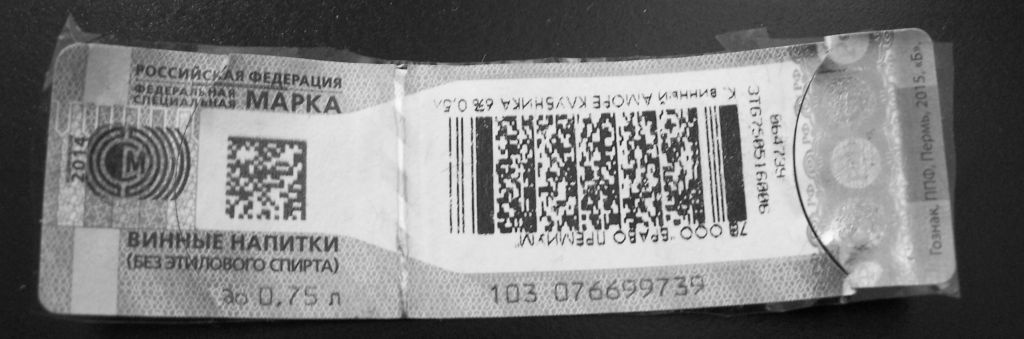

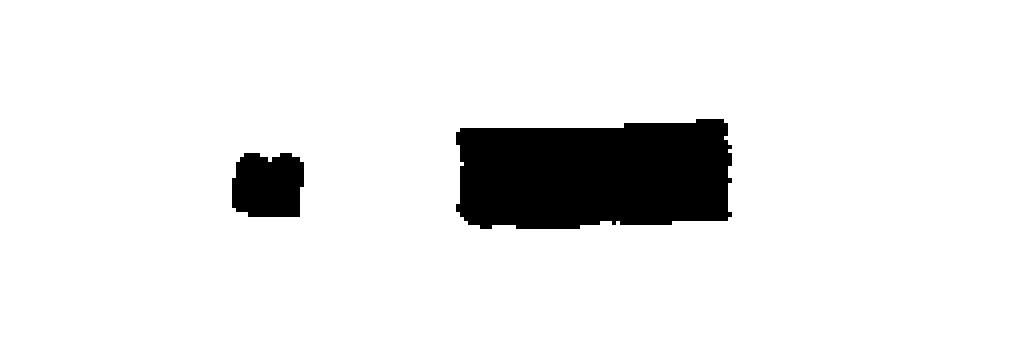

In [4]:
# Посмотрим, что там у нас с данными
display(Image.fromarray(images[0]))
display(Image.fromarray(segmaps[0]))

In [5]:
!pip install -qU torch_snippets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.1.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [6]:
from torch_snippets import *
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms
import pandas as pd
import glob
from sklearn.model_selection import train_test_split

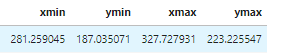

In [8]:
import os

path_Images = "/kaggle/input/abbyy-dataset/Train/Image"
Images = os.listdir(path_Images)
num_images = {}
for i in Images:
    num_images[i.split('.')[0]] = i

In [9]:
path_Markup = "/kaggle/input/abbyy-dataset/Train/Markup"
Markups = os.listdir(path_Markup)

In [21]:
import ast

path = '/kaggle/input/abbyy-dataset/Train/Image/'
df = {'ImageID':[],
      'xmin':[],
      'ymin':[],
      'xmax':[],
      'ymax':[]}

for markup in Markups:
    d = pd.read_csv(path_Markup+'/'+markup, sep="\t")
    s = d['Bounding box'][0].split(";")
    df['xmin'].append(ast.literal_eval(s[0])[0])
    df['ymin'].append(ast.literal_eval(s[0])[1])
    df['xmax'].append(ast.literal_eval(s[1])[0])
    df['ymax'].append(ast.literal_eval(s[1])[1])
    df['ImageID'].append(num_images[markup.split('.')[0]])
    
IMG_ROOT = '/kaggle/input/abbyy-dataset/Train/Image'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
df = pd.DataFrame(df)
df

,ImageID,xmin,ymin,xmax,ymax
0,0029.jpg,129,169,258,241
1,0094.jpg,298,273,526,362
2,0074.tif,125,111,741,390
3,0075.tif,41,105,478,366
4,0038.tiff,1991,482,2048,1578
...,...,...,...,...,...
90,0044.tif,1652,2764,2050,3163
91,0077.tif,202,866,986,904
92,0027.png,2030,1195,2486,1262
93,0004.tiff,430,1141,1526,1197


In [29]:
from PIL import Image
im = Image.open('/kaggle/input/abbyy-dataset/Test/Image/0001.tif')
im.show()

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmppzfxou3h.PNG'


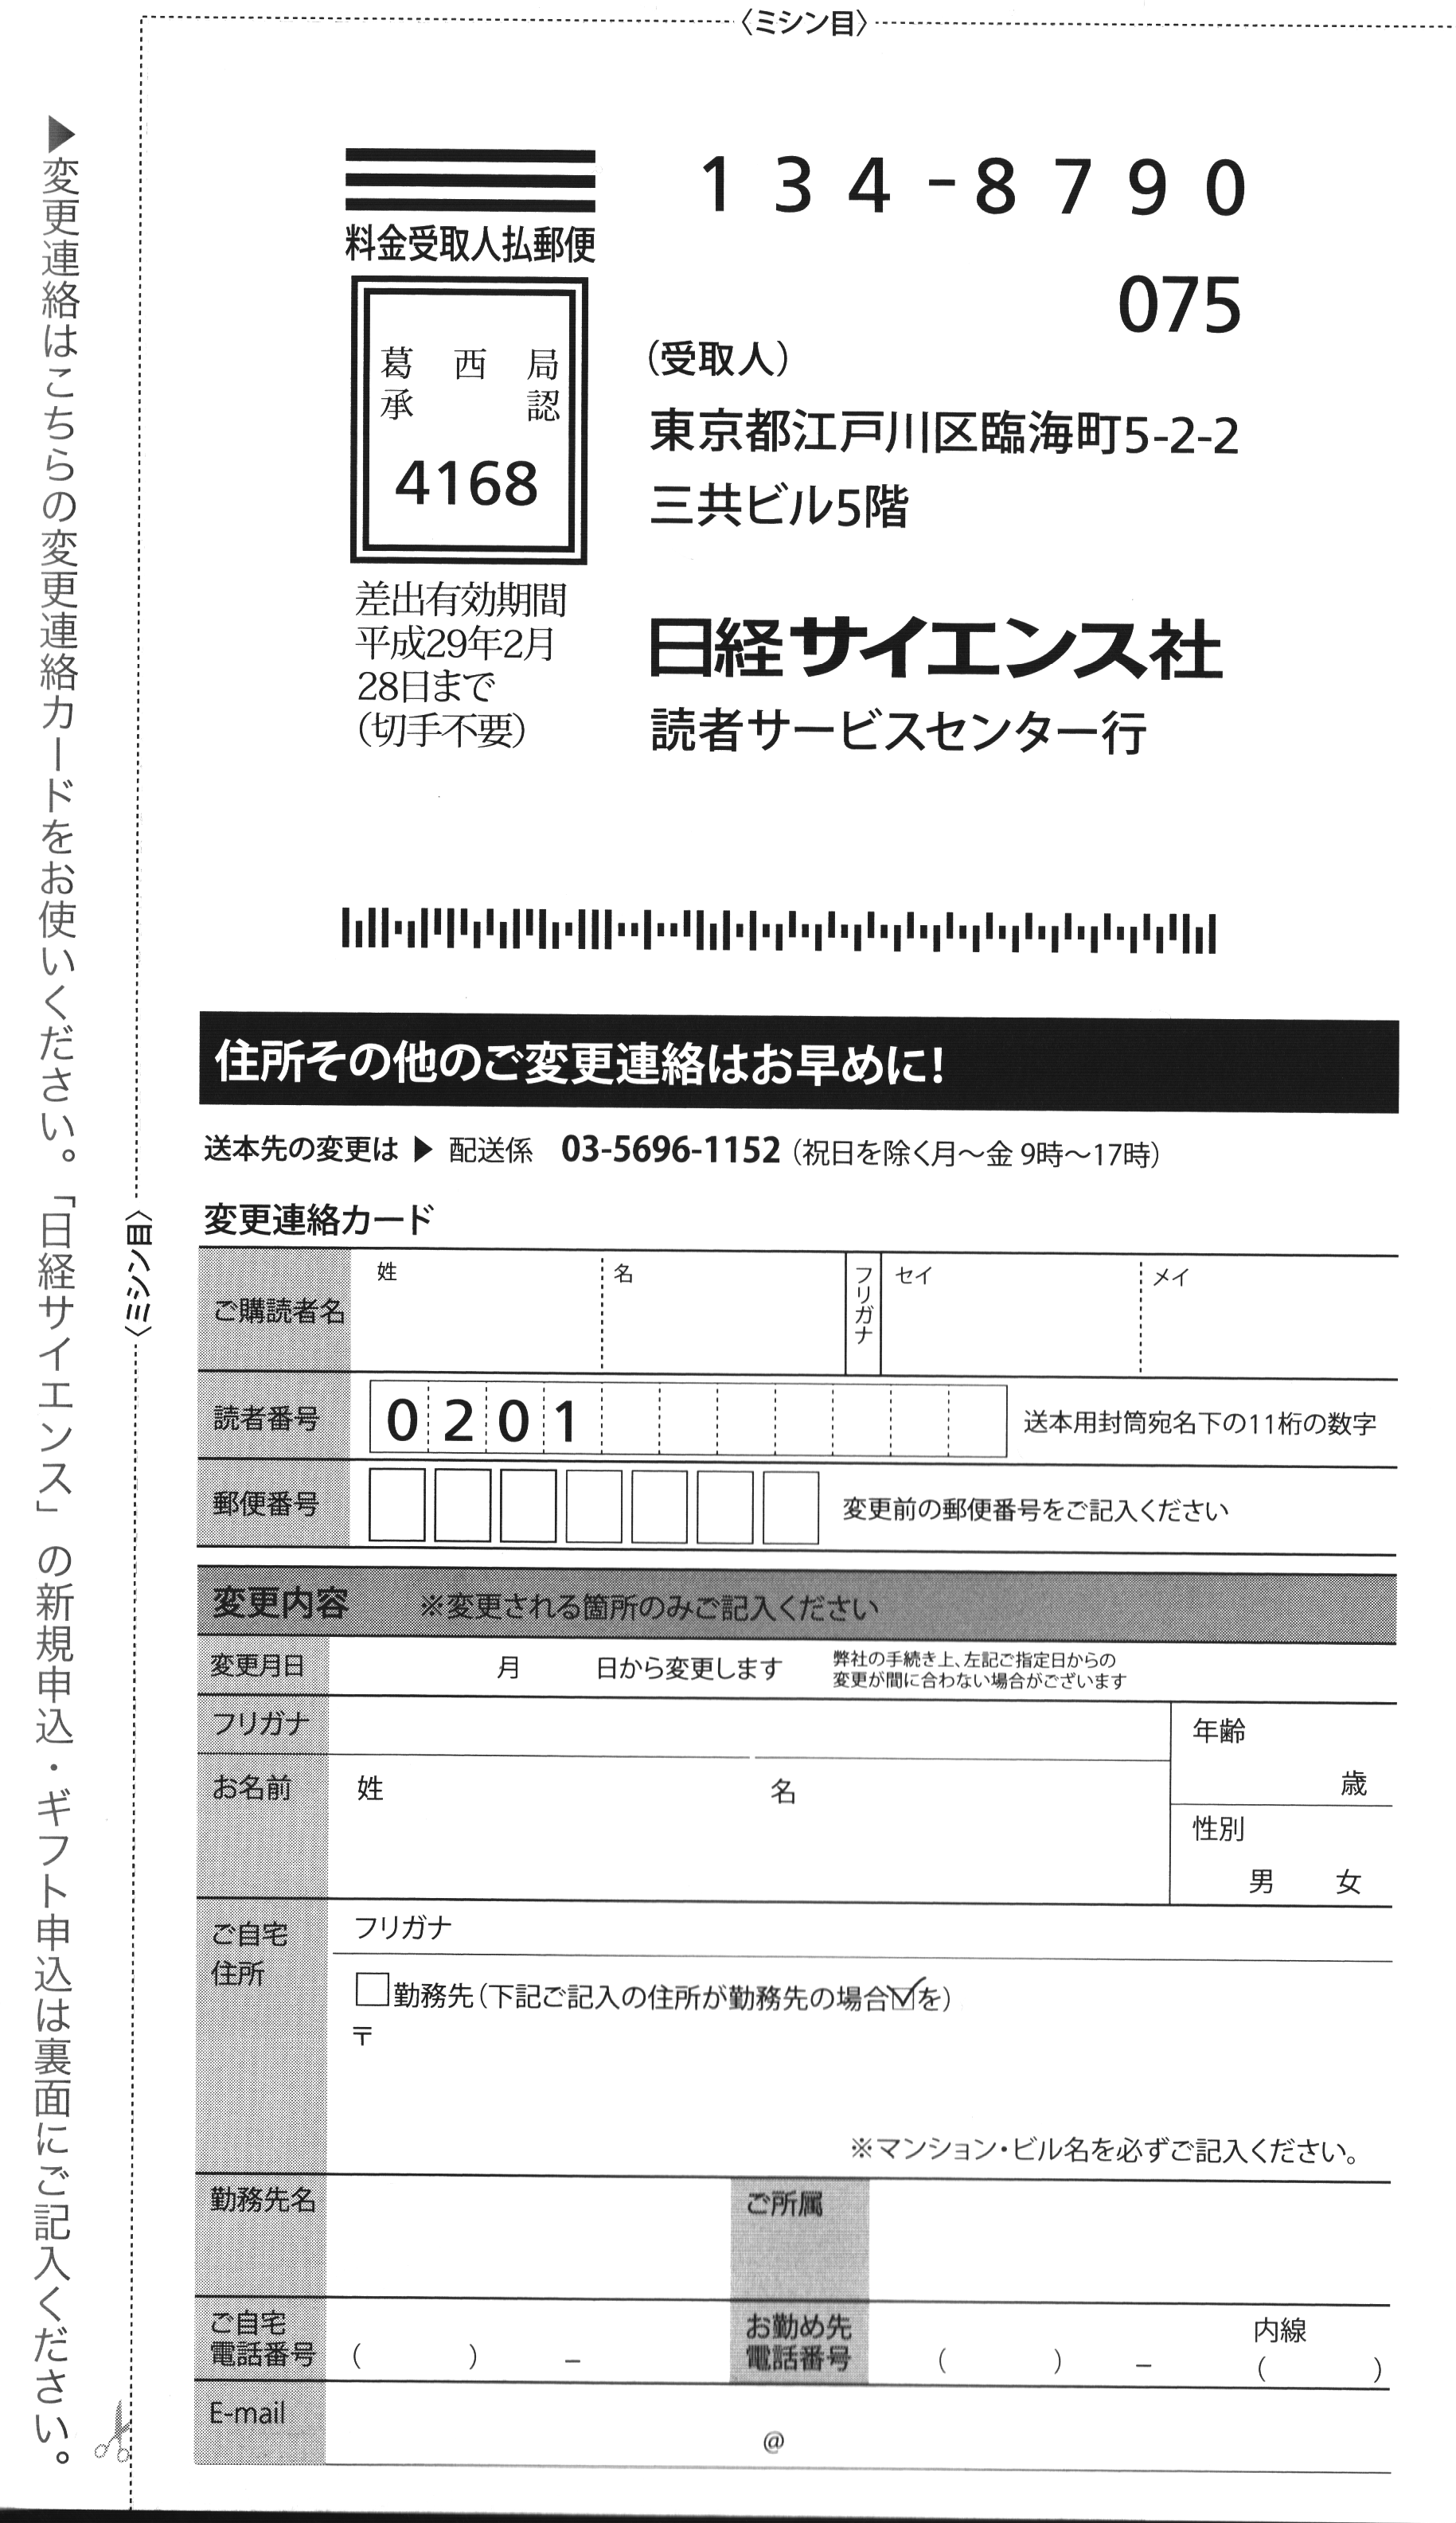

In [34]:
image = cv2.imread('/kaggle/input/abbyy-dataset/Train/Image/0004.tiff', cv2.IMREAD_GRAYSCALE)
display(Image.fromarray(image))

In [22]:
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

(85, 10)

In [23]:
label2target = {'background': 0 , 'barcode' : 1  }
target2label = { t: l for l,t in  label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [13]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [14]:
class OpenDataset(Dataset):
    def __init__(self, df, image_dir):
        self.w, self.h = 224, 224
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df.copy()
        self.image_infos = df.ImageID.unique()
        
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        data = self.df[self.df['ImageID'] == image_id]
        H, W , _ = np.array(img).shape
        data.loc[:, ['xmin', 'ymin', 'xmax', 'ymax']] /= [W, H, W, H]
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        labels = ['barcode'] * len(data)
        data = data[['xmin','ymin','xmax','ymax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() 
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)

In [15]:
train_ds = OpenDataset(trn_df, IMG_ROOT)
test_ds = OpenDataset(val_df , IMG_ROOT)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

In [16]:
def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features # number of input channels
                                                    , num_classes)
    return model

In [17]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
    #and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [18]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 20
log = Report(n_epochs)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 116MB/s]  


In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 0.143  trn_loss: 0.284  trn_loc_loss: 0.137  trn_regr_loss: 0.133  trn_objectness_loss: 0.013  trn_rpn_box_reg_loss: 0.003  (8.38s - 1164.54s remaining)

UnidentifiedImageError: cannot identify image file '/kaggle/input/abbyy-dataset/Train/Image/0041.tif'

In [ ]:
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

In [ ]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
   # print(len(images))
    if ix==3: break
    images = [im for im in images]
    #print(images[0].size())
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)

### Оказалось, гипотеза на карте сегментации немного меньше, чем сам баркод. Можно регион прямоугольника попробовать настроить

In [12]:
# Собираем гипотезы с карты сегментации.
# Возвращает лист повернутых прямоугольников
def get_barcodes_rects(segmap):
    # Собираем компоненты
    # Слишком мелкие не учитываем
    min_area = 10
    binary_map = np.where(segmap < 128, 1, 0)
    binary_map = np.array(binary_map, dtype=np.uint8)
    cnts, _ = cv2.findContours(binary_map, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    cnts = list(filter(lambda cnt: cv2.contourArea(cnt) > min_area, cnts))
    boxes = [cv2.boxPoints(cv2.minAreaRect(cnt)) for cnt in cnts]
    assert len(boxes) == len(cnts)
    return boxes

In [13]:
import math

# Расширяем прямоугольник
def scale_single_box(rotated_box):
        ratio = 0.1
        border_points = np.reshape(rotated_box, (-1, 2)).astype(np.float)
        # т.к. прямоугольник, берем минимум из двух сторон
        min_side = min(np.linalg.norm(border_points[0] - border_points[1]),
                       np.linalg.norm(border_points[1] - border_points[2]))
        indent = ratio * min_side
        new_border_points = []
        for idx, point in enumerate(border_points):
            first_side_vector = border_points[idx - 1] - point
            first_side_vector /= np.linalg.norm(first_side_vector)
            second_side_vector = border_points[idx + 1 - border_points.shape[0]] - point
            second_side_vector /= np.linalg.norm(second_side_vector)

            new_point = point - indent * (first_side_vector + second_side_vector)
            new_border_points.append(new_point)
        return np.asarray(new_border_points)


# Получим все гипотезы с изображения
hypotheses = get_barcodes_rects(segmaps[0])

# Для отрисовки границы сделаем изображение цветным
img = cv2.cvtColor(images[0], cv2.COLOR_GRAY2RGB)

# Зеленым будет нарисован самый простой вариант
# Синим нарисован расширенный вариант
for hypothesis in hypotheses:
    new_box = np.int0(hypothesis)
    cv2.drawContours(img, [new_box], 0, (0, 255, 0), 2)
    new_box = scale_single_box(new_box).astype(np.int)
    cv2.drawContours(img, [new_box], 0, (0, 0, 255), 2)
display(Image.fromarray(img))

/tmp/ipykernel_33/3876002017.py:32: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  new_box = np.int0(hypothesis)


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

### Ниже видно, что между штрихкодами есть просветы, можно по ним резать

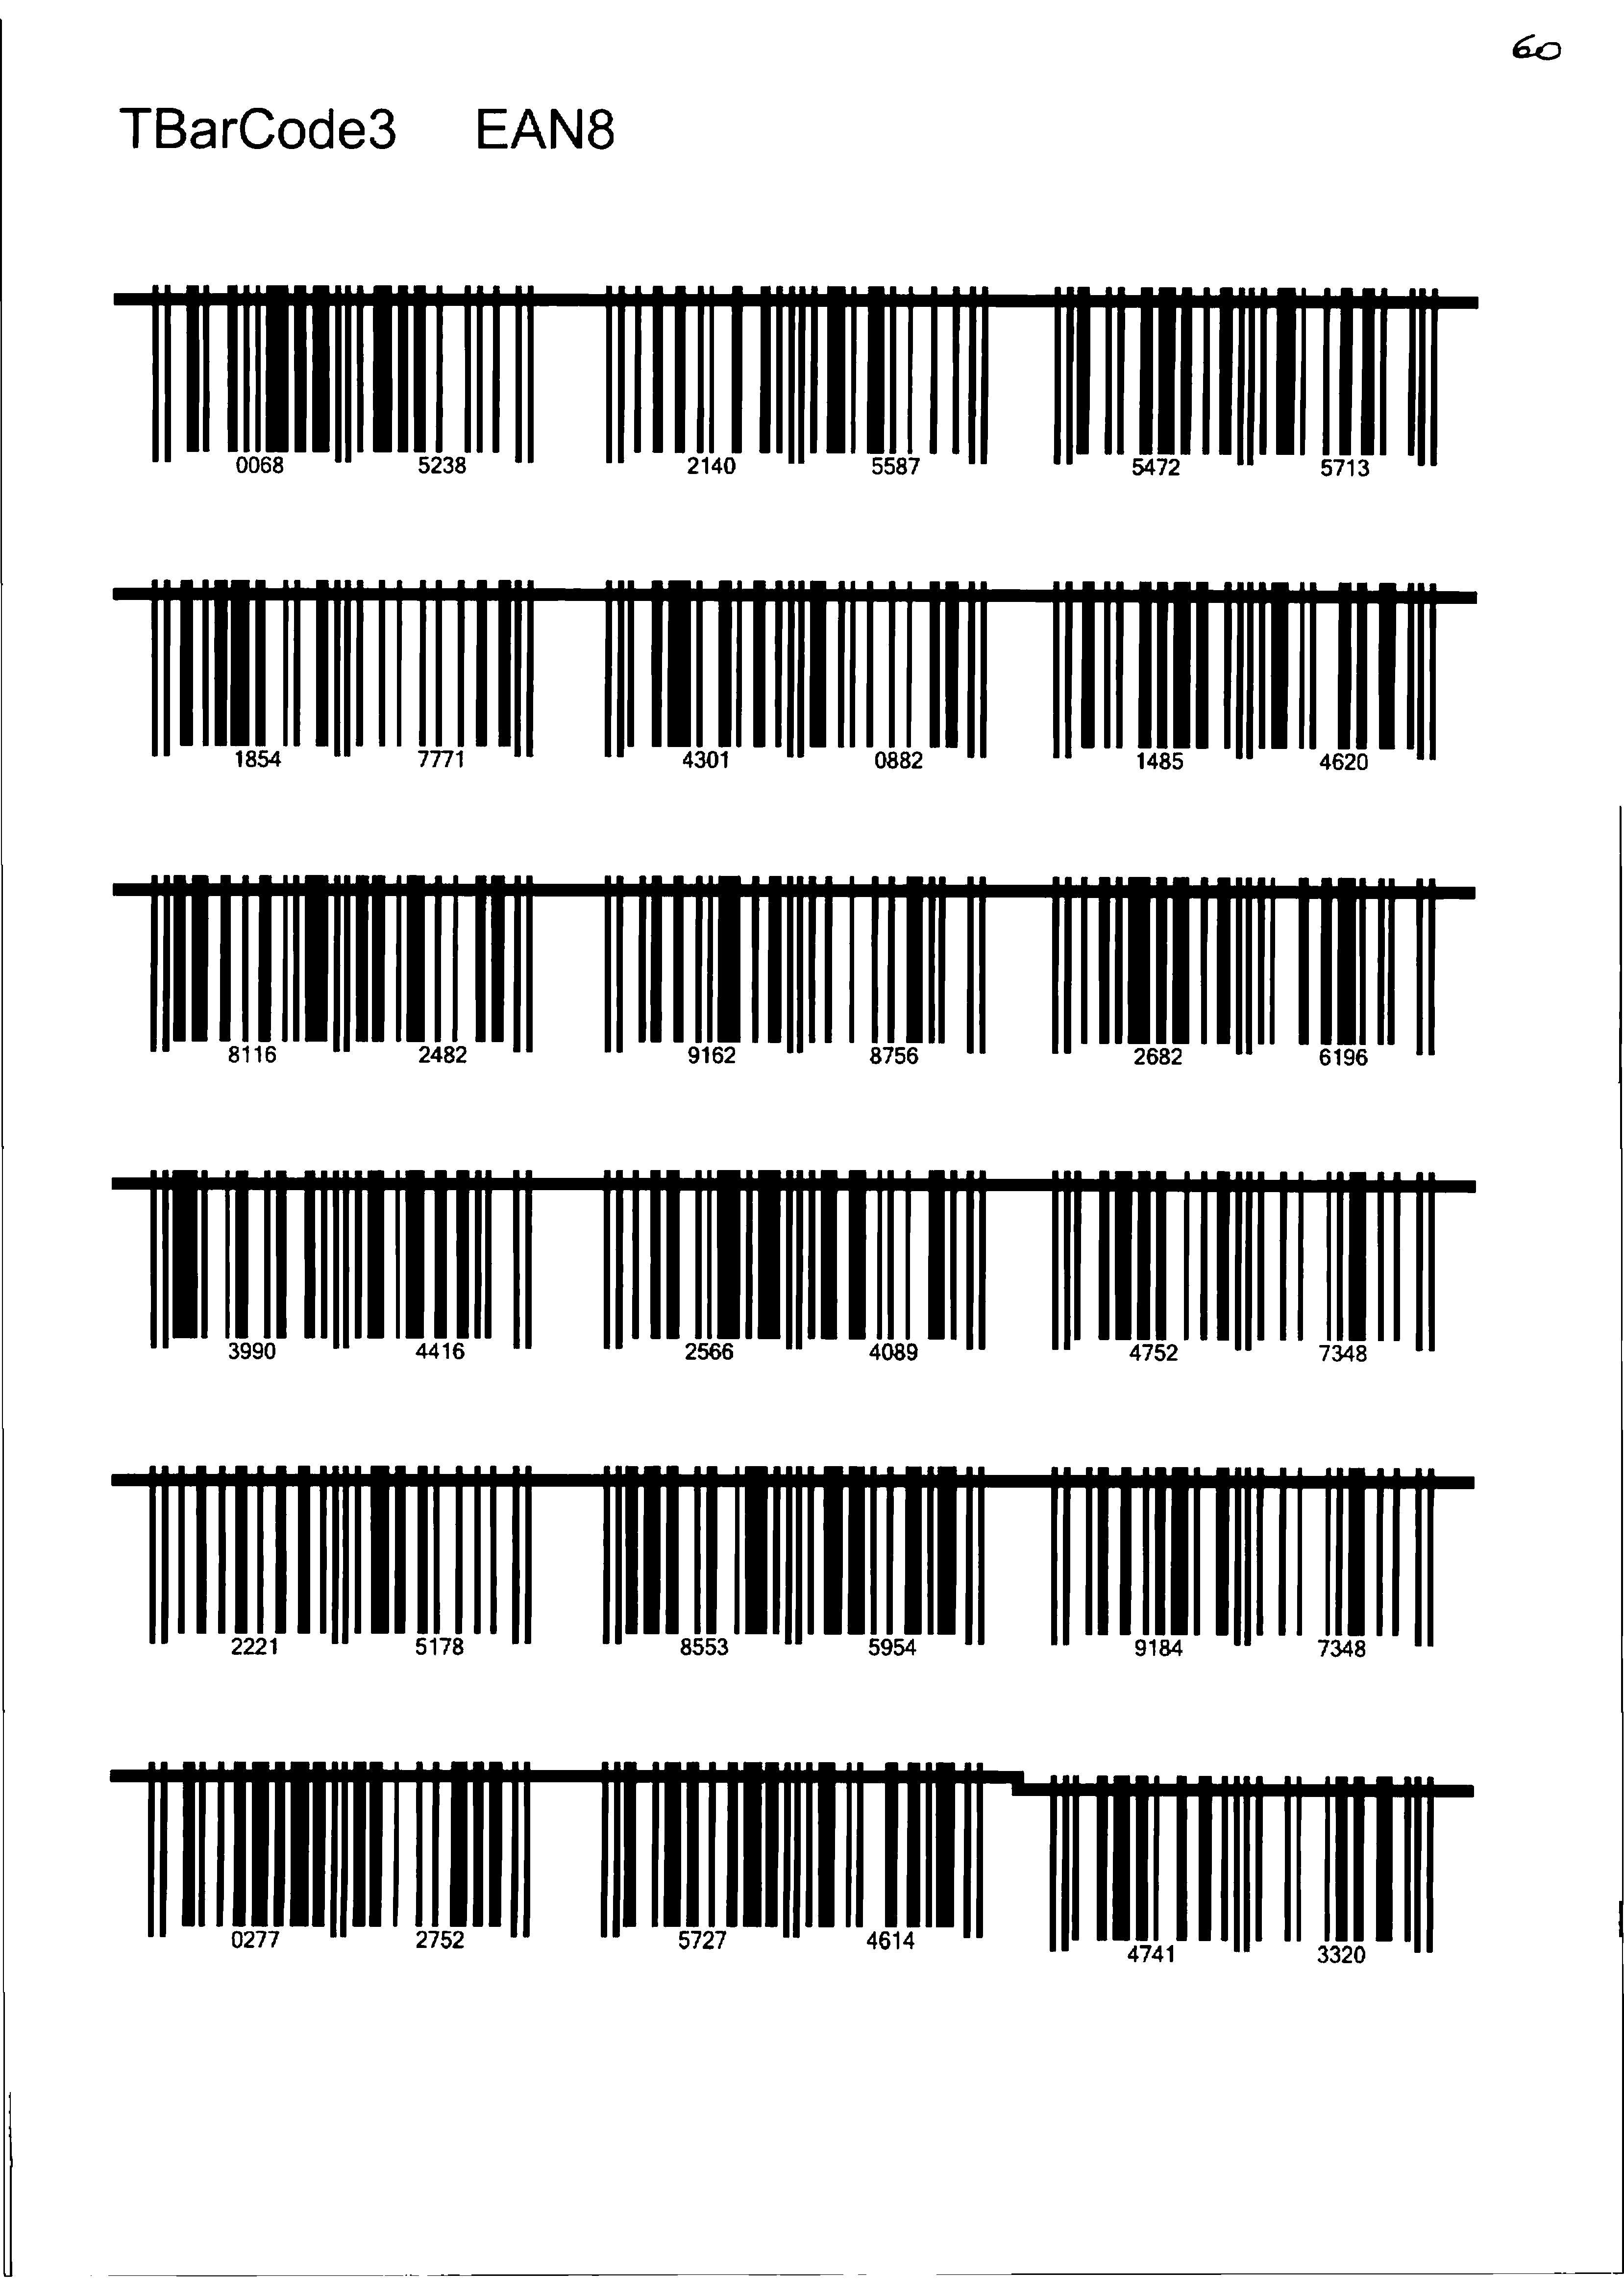

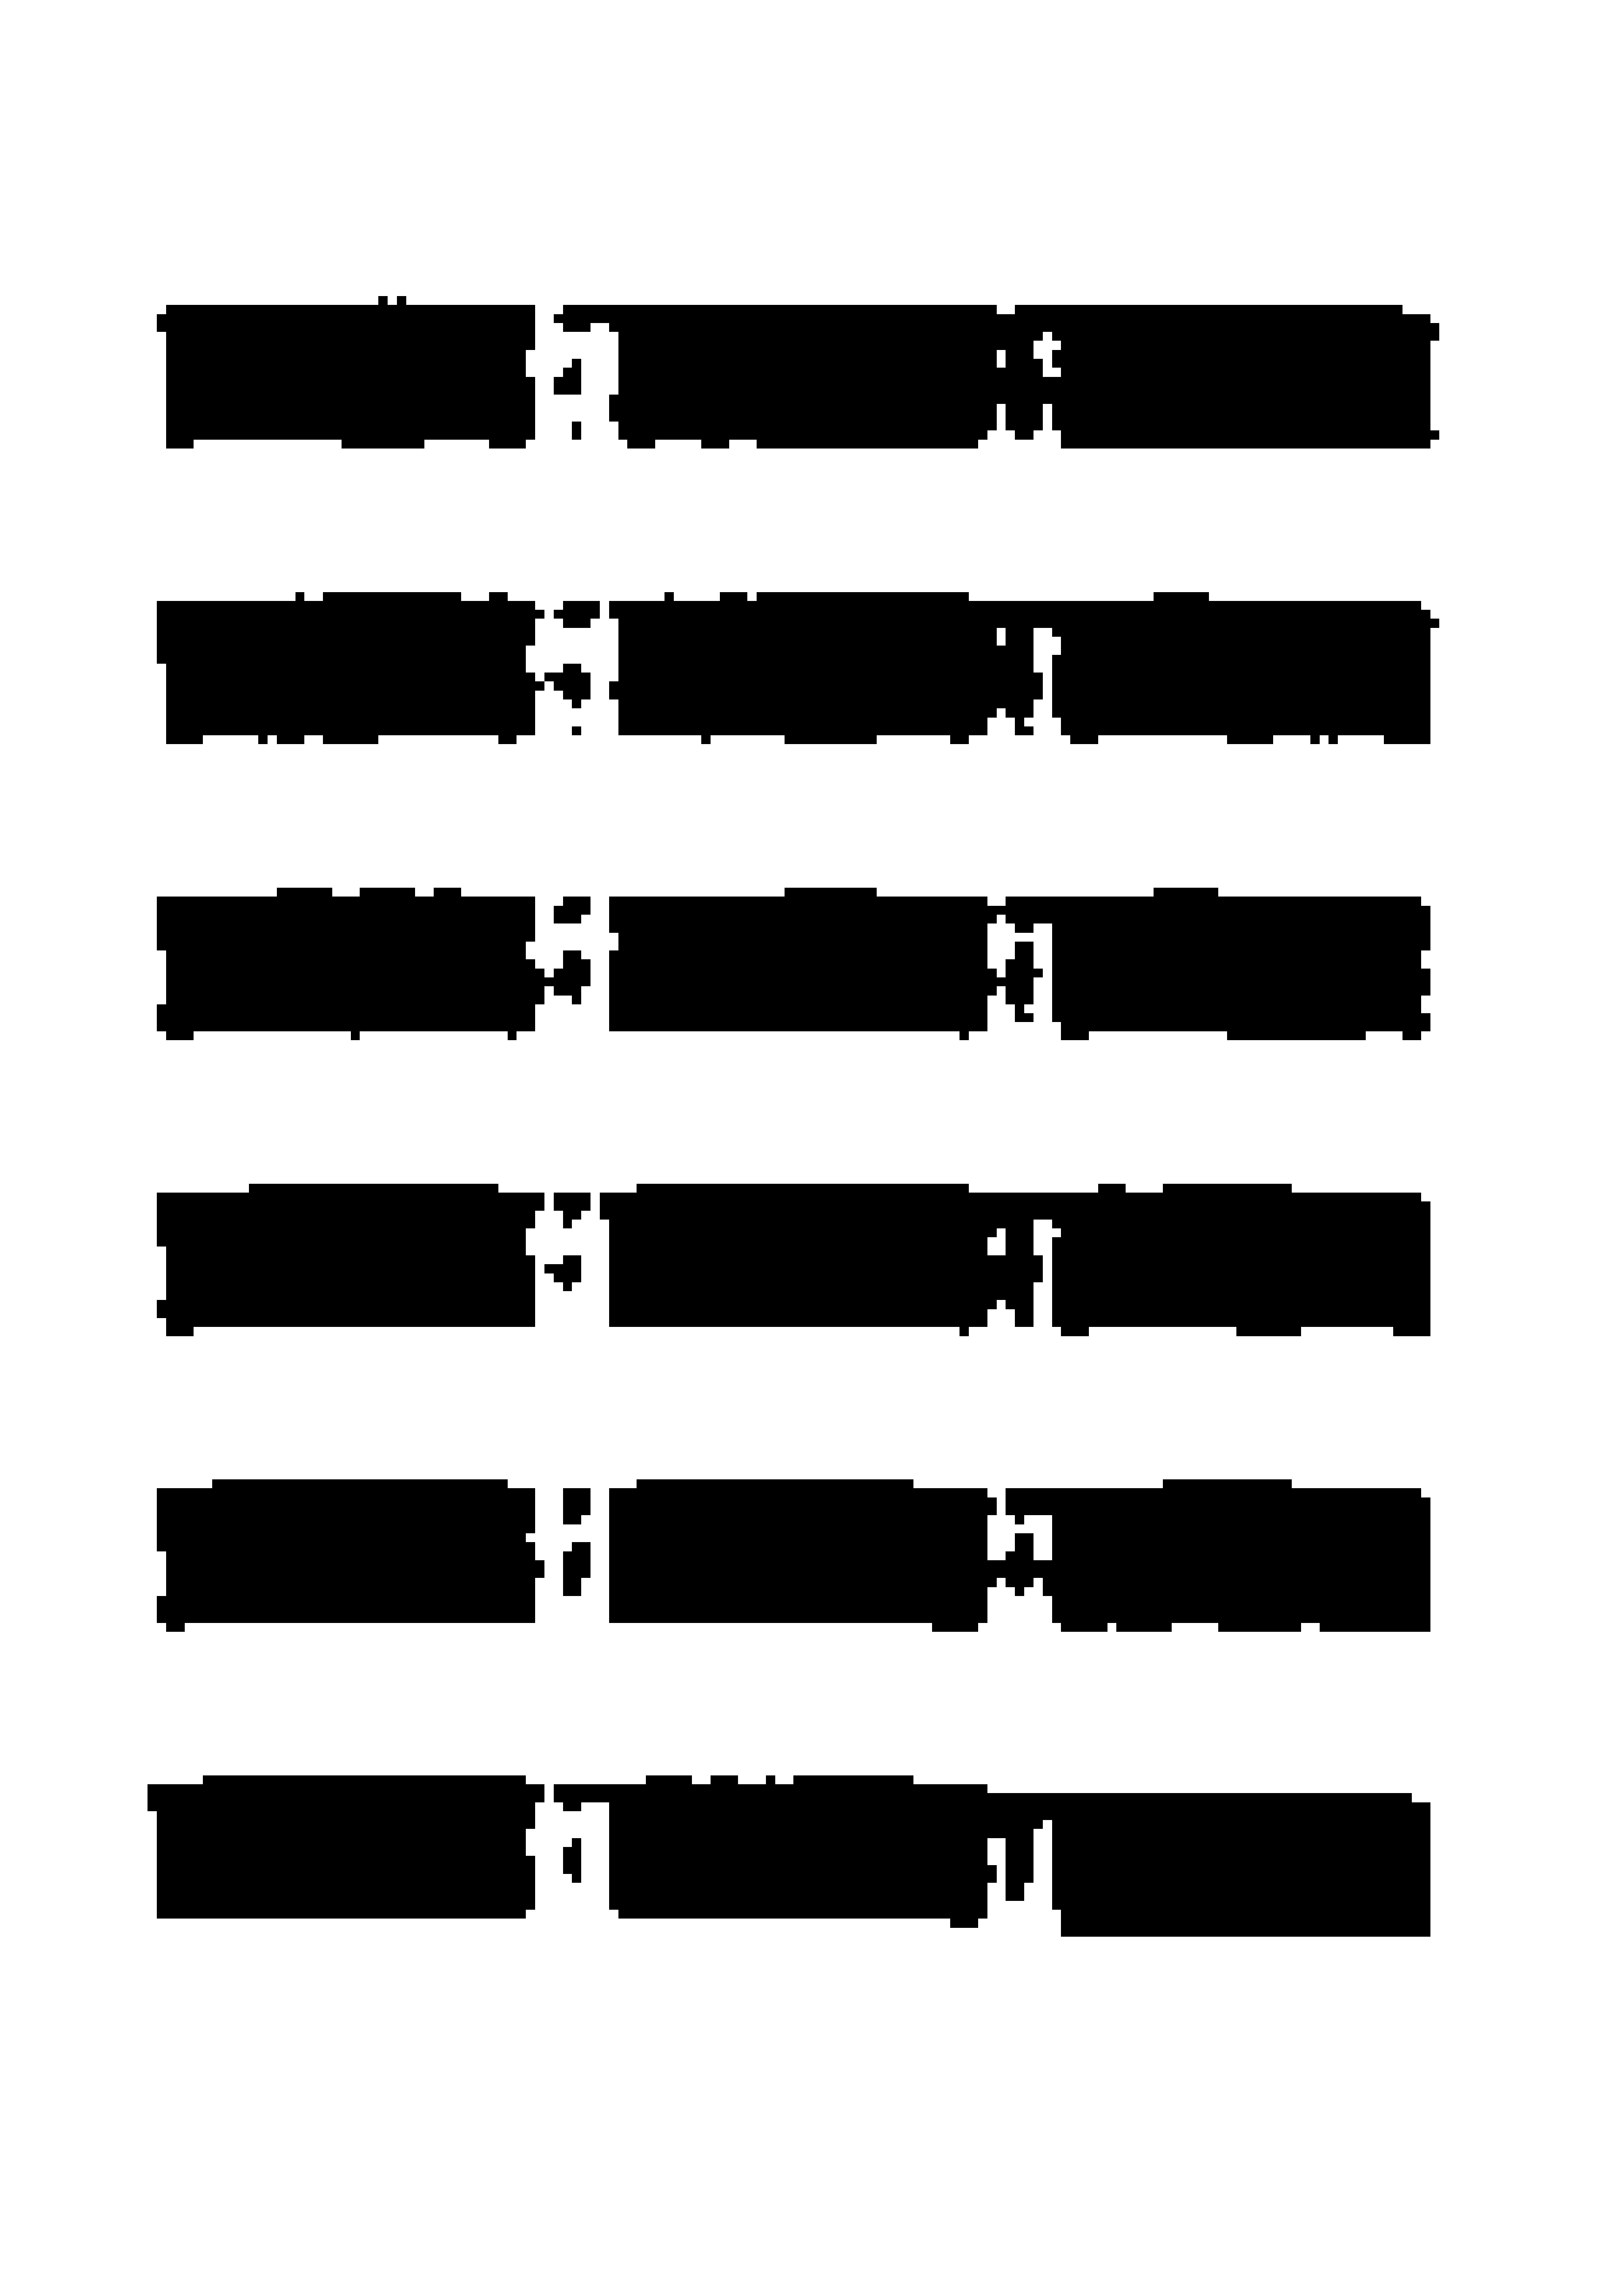

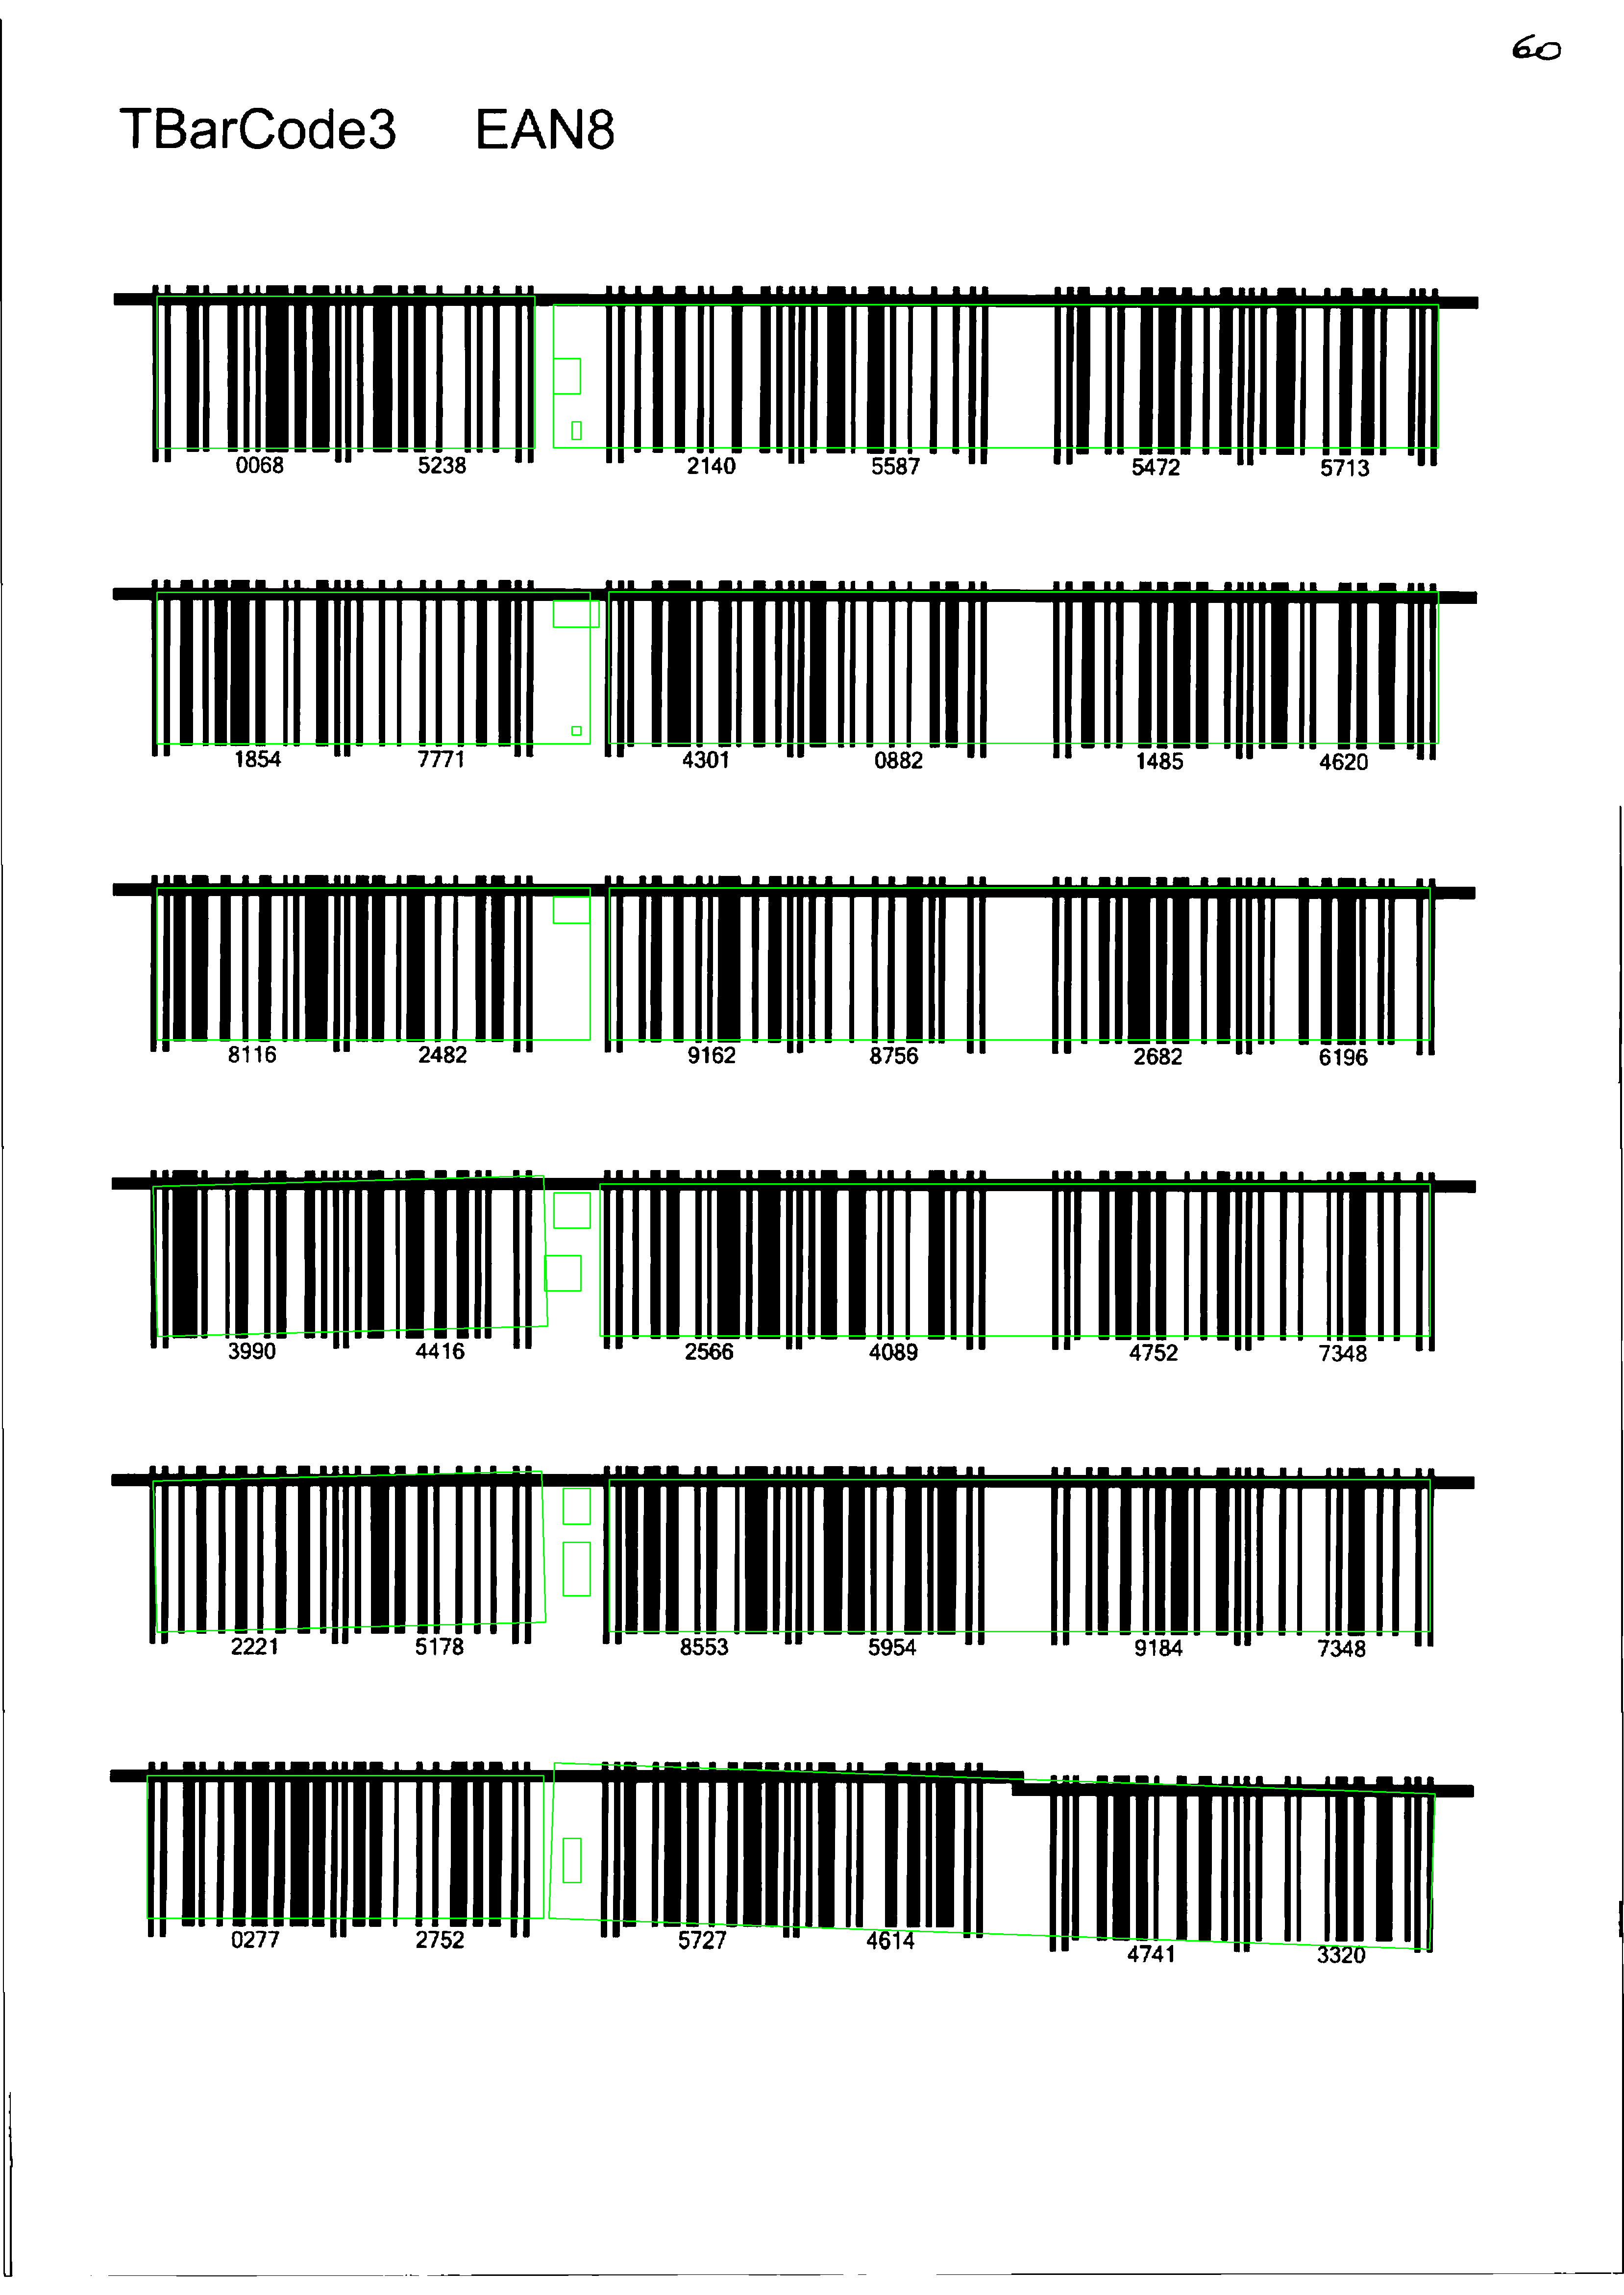

In [7]:
display(Image.fromarray(images[1]))
display(Image.fromarray(segmaps[1]))
hypotheses = get_barcodes_rects(segmaps[1])
img = cv2.cvtColor(images[1], cv2.COLOR_GRAY2RGB)
for hypothesis in hypotheses:
    new_box = np.int0(hypothesis)
    cv2.drawContours(img, [new_box], 0, (0, 255, 0), 2)
display(Image.fromarray(img))

Можно вырезать гипотезу из изображения, сложить значения всех пикселей в каждом столбце изображения и мы получим массив значений -
проекцию изображения на горизонтальную ось. Уже на ней можно найти отрезки с низким значением и по ним порезать. Так мы поймаем
белые просветы в гипотезе.

С вертикальной осью можем поступить аналогично.

### Прочие советы

1. На примере выше можно заметить, что есть гипотезы, у которых справа или слева захвачено большое белое поле.
Такие поля можно обрезать.
2. Иногда вместо белого поля по краям изображения есть незначительный сигнал - шум.
Его тоже можно отрезать для повышения точности границ гипотезы.
3. Карта сегментации может "распадаться" либо на больших штрихкодах, либо на совсем мелких. Здесь стоит подумать над алгоритмом, который сможет склеивать мелкие запчасти в целый кусок.

Ну а здесь в качестве baseLine сделаем только scale гипотезы и покажем, как правильно писать в файл

In [8]:
result = []
for i, segmap in enumerate(segmaps):
    hypotheses = get_barcodes_rects(segmap)
    current_result = []
    for hypothesis in hypotheses:
        new_box = np.int0(hypothesis)
        new_box = scale_single_box(new_box).astype(np.int)
        current_result.append(new_box)
    result.append(current_result)  

In [9]:
print(len(result))
print(result[0])

181

[array([[271, 488],

       [279, 488],

       [279, 492],

       [271, 492]]), array([[237, 213],

       [457, 213],

       [457, 541],

       [237, 541]])]


### Пишем результат в файл

In [10]:
import csv

# Записываем координаты области в виде [x0, y0];[x1, y1];[x2, y2];[x3, y3]
def format_rotated_box_string(points):
    assert len(points) == 4
    str_res = ""
    for pair in points:
        str_res = str_res + f"[{pair[0]}, {pair[1]}];"
    return str_res[:-1]
        
        
with open('./output.tsv', 'wt', newline="") as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    from os import listdir
    for i, file in enumerate(listdir(images_path)):
        import os
        only_name = os.path.splitext(file)[0]
        for res in result[i]:
            tsv_writer.writerow([only_name, format_rotated_box_string(res)])
